# Images processing

The aim is to generate images for **maptcha** in a programmatic (automated?) way.
We have the RGB ("true" image from satellite/UAV, `.tif`) and the labels/prediction results (vectorial, so it can be shown "on top" of the RGB, `.geojson`). We want to have a single image out of these 2, a `jpg`, where they are overlaid.

The aim is to have square (is the shape important?) images with one polygon each (for T and F positives), or non-polygon (for T and F negatives).

The 2 alternative questions to the user, for us to detect the 4 categories above, would be:

- Does this polygon outline a building?
TP image and FP image

- Is there a building here (that is not outlined)?
TN image and TN image

We work on the geojson files, for both the labels and prediction, to find the 4 categories by overlap.

Using the functions written by Kshitij [here](https://github.com/kshitijrajsharma/evaluator/).
Can test in this beta app [here](https://segevaluator.streamlit.app/) too.


### Data handling

In [1]:

# Create env if doesn't exist yet
# $conda env create -f requirements.yaml
# $pip install -r requirements.txt

In [1]:
# Import modules
import os
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio import plot as rasterplot
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import custom modules
import evaluate
from evaluate import calculate_overlap_metrics, classify_prediction, analyze_predictions

In [3]:
# Define paths and upload data
basic_path = '/Users/azanchetta/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/Research/projects/Maptcha/data/fair'
image_sample_name = 'OAM-792703-461055-20'

rgb_filename_with_path = f'{basic_path}/rgb/{image_sample_name}.tif'
labels_filename_with_path = f'{basic_path}/labels/{image_sample_name}.geojson' # single sample tile
mask_filename_with_path = f'{basic_path}/masks/{image_sample_name}.mask.tif'
pred_raster_filename_with_path = f'{basic_path}/predictions/{image_sample_name}.tif'
pred_vect_filename_with_path = f'{basic_path}/predictions/prediction_20.geojson' # all the labels in one file (many tiles)
labels_tot_filename_with_path = f'{basic_path}/labels/labels_20.geojson'

In [4]:
labels = gpd.read_file(labels_tot_filename_with_path)
pred_vect = gpd.read_file(pred_vect_filename_with_path)

In [5]:
labels.head()

,osm_id,tags,layer,path,geometry
0,625240244,"{ ""building"": ""yes"" }",OAM-792656-461054-20,/Users/azanchetta/fAIr_metric/training_results...,"POLYGON ((10256657.293 2416673.466, 10256664.4..."
1,625236908,"{ ""building"": ""yes"" }",OAM-792656-461054-20,/Users/azanchetta/fAIr_metric/training_results...,"POLYGON ((10256645.359 2416678.194, 10256645.3..."
2,678320817,"{ ""building"": ""yes"" }",OAM-792656-461054-20,/Users/azanchetta/fAIr_metric/training_results...,"POLYGON ((10256631.133 2416677.096, 10256632.6..."
3,625236916,"{ ""building"": ""yes"" }",OAM-792656-461054-20,/Users/azanchetta/fAIr_metric/training_results...,"POLYGON ((10256626.357 2416684.391, 10256626.3..."
4,679363324,"{ ""building"": ""yes"" }",OAM-792656-461054-20,/Users/azanchetta/fAIr_metric/training_results...,"POLYGON ((10256631.199 2416682.612, 10256633.3..."


In [6]:
print(len(labels))

202


In [ ]:
labels.explore()

In [9]:
pred_vect.head()

,geometry
0,"POLYGON ((92.13712 21.20779, 92.13712 21.20779..."
1,"POLYGON ((92.13688 21.20782, 92.13688 21.20783..."
2,"POLYGON ((92.13691 21.2078, 92.13692 21.20782,..."
3,"POLYGON ((92.13688 21.20786, 92.13688 21.20787..."
4,"POLYGON ((92.13712 21.2079, 92.13713 21.2079, ..."


In [6]:
print(len(pred_vect))

163


In [ ]:

pred_vect.explore()

In [12]:
rgb = rasterio.open(rgb_filename_with_path)
mask = rasterio.open(mask_filename_with_path)
pred_raster = rasterio.open(pred_raster_filename_with_path)

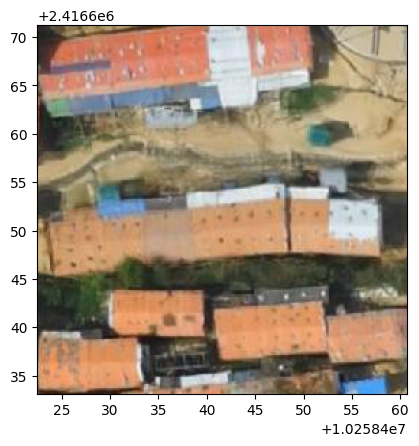

<Axes: >

In [13]:
show(rgb)

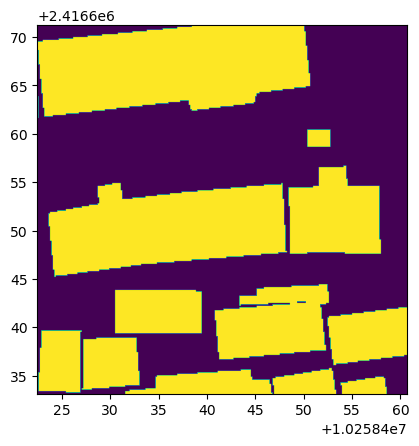

<AxesSubplot: >

In [204]:
show(mask)

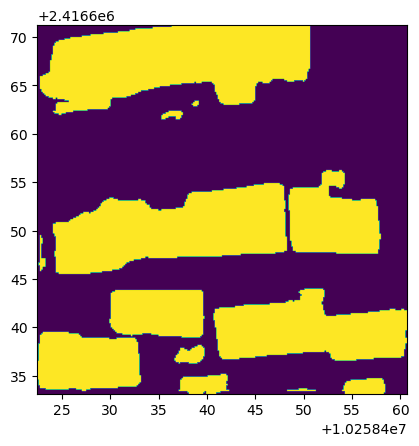

<AxesSubplot: >

In [205]:
show(pred_raster)

### Data processing

Vectorial approach

In [ ]:
prediction_gdf, pred_metrics = analyze_predictions(pred_vect, labels, overlap_threshold=80)

### Creating the figures

In [9]:
categories_file = '/Users/azanchetta/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/Research/projects/Maptcha/data/predictions_analyzed_20241022_221348.geojson'

In [28]:
categories_gpd = gpd.read_file(categories_file)

In [22]:
categories_gpd.head()

,classification,overlap_percentage,iou,area,osm_id,tags,layer,path,geometry
0,TP,57.77138418303781,0.4474849336727621,1.010007e-09,NaN,None,None,None,"POLYGON ((92.13712 21.20779, 92.13712 21.20779..."
1,TP,86.2326955394267,0.5317086014343128,3.625137e-10,NaN,None,None,None,"POLYGON ((92.13688 21.20782, 92.13688 21.20783..."
2,TP,88.24645656380216,0.8398600808572373,4.785454e-09,NaN,None,None,None,"POLYGON ((92.13691 21.2078, 92.13692 21.20782,..."
3,TP,58.29711572649372,0.5379043175898831,2.201420e-10,NaN,None,None,None,"POLYGON ((92.13688 21.20786, 92.13688 21.20787..."
4,TP,86.7875823674186,0.5162236537506806,4.981611e-09,NaN,None,None,None,"POLYGON ((92.13712 21.2079, 92.13713 21.2079, ..."


In [29]:
categories_gpd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
categories_gpd.explore(column="classification",  # use "Set1" matplotlib colormap
    style_kwds=dict(color="black"))

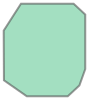

In [36]:
categories_gpd['geometry'][1]

In [27]:
rgb.crs

CRS.from_epsg(3857)

In [41]:
categories_gpd = categories_gpd.to_crs("epsg:3857")

In [42]:
categories_gpd.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

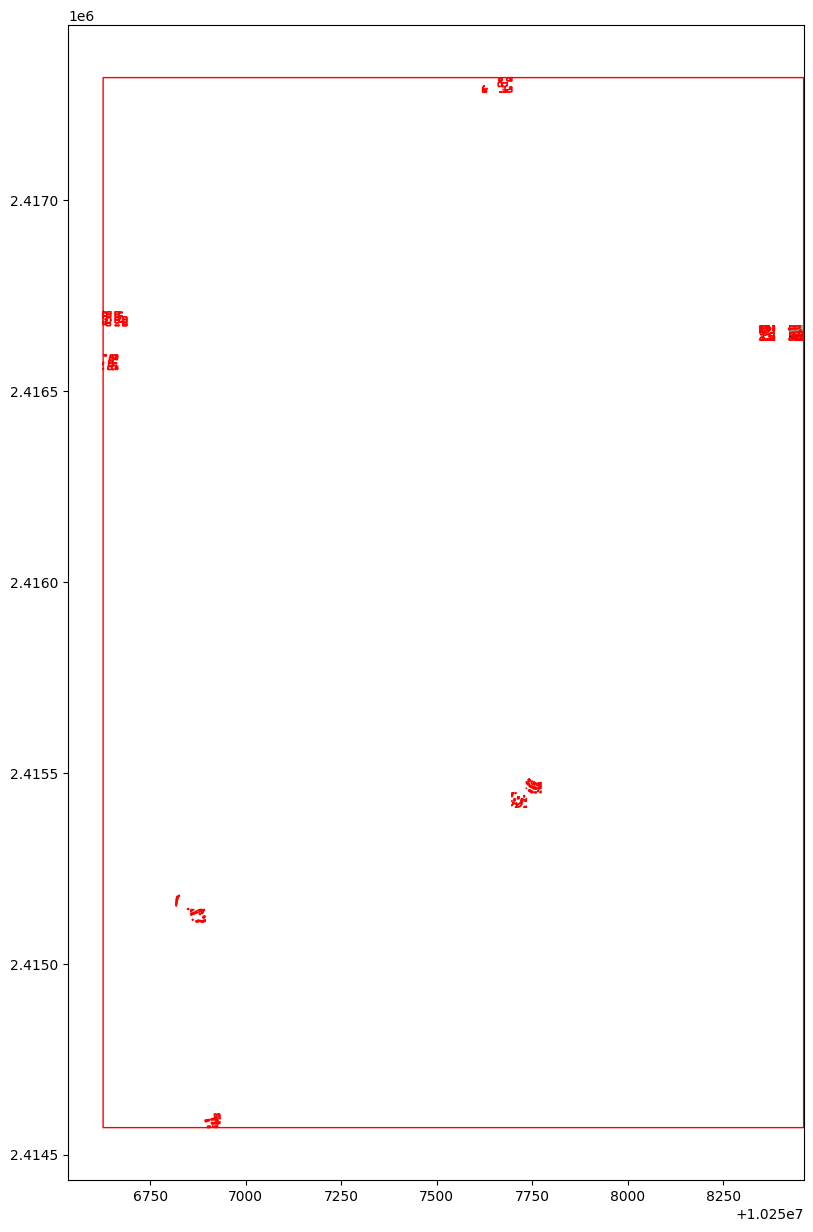

In [48]:
# Script for generating "collapsed" tif and geojson figure
# from https://stackoverflow.com/questions/61980063/how-to-place-a-shapefile-on-top-of-raster-file-in-one-plot-and-then-save-the-pl

# this is how you'd open the raster dataset if you have one
#tiff = rasterio.open('example.tif')

# ax = categories_gpd.plot()

# show(rgb, ax=ax)

fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(rgb, ax=ax)
categories_gpd.plot(ax=ax, facecolor='none', edgecolor='red')


In [ ]:
# Script to separate image in tiles (this cuts the whole image, maybe not relevant)
# https://stackoverflow.com/questions/34940529/fastest-method-of-splitting-image-into-tiles
# https://stackoverflow.com/questions/5953373/how-to-split-image-into-multiple-pieces-in-python

---

Code for raster approach (scraped)

In [207]:
# Obtain data for T/F P/N
# diff = mask - pred_raster #### too simple!! apparently to subtract rasters we need numpy:
# https://gis.stackexchange.com/questions/463797/calculating-difference-between-two-raster-layers-in-python
mask_np = mask.read(1) #Read first band (only band) as a numpy array
pred_raster_np = pred_raster.read(1)

mask_np[np.isin(mask_np, 0)]=10
pred_raster_np[np.isin(pred_raster_np, 0)]=40
pred_raster_np[np.isin(pred_raster_np, 255)]=50

diff = mask_np - pred_raster_np
diff2 = pred_raster_np - mask_np


In [208]:
type(diff)

numpy.ndarray

In [209]:
np.unique(mask_np)

array([ 1, 10], dtype=uint8)

In [210]:
np.unique(diff)

array([207, 216, 217, 226], dtype=uint8)

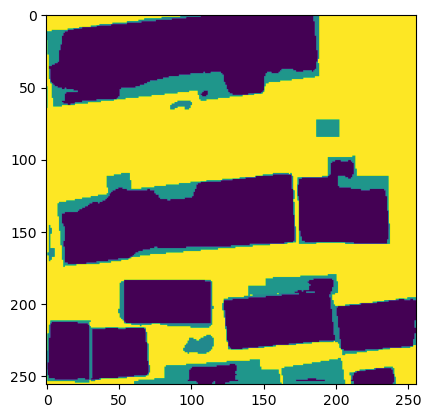

<AxesSubplot: >

In [211]:
show(diff)